In [1]:
import pandas as pd
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

data_path = Path("../data/processed/processed_data.csv")
accident_dfs = pd.read_csv(data_path)


## Test01-Chi-Square test

In [2]:
from scipy.stats import chi2_contingency
import pandas as pd

accident_dfs["SEVERITY"] = (accident_dfs["FATALS"]>1).astype(int) #feature engineering

#Build contigency table
contingency = pd.crosstab(
    accident_dfs['WEATHERNAME'],
    accident_dfs['SEVERITY']
)

chi2, p_value, dof, expected = chi2_contingency(contingency)

print(f"Chi-Square Statistic: {chi2:.2f}")
print(f"P-value: {p_value:.6f}") #p<0.0001
print(f"Degrees of Freedom: {dof}") 

Chi-Square Statistic: 38.76
P-value: 0.000115
Degrees of Freedom: 12


## Odds Ratio

In [3]:
# Calculate odds ratio for each weather vs Clear
clear = accident_dfs[accident_dfs['WEATHERNAME'] == 'Clear']
c = len(clear[clear['SEVERITY'] == 1]) # multi-fatal in clear
d = len(clear[clear['SEVERITY'] == 0]) # single-fatal in clear
# print(c)
# print(d)
# print(accident_dfs["WEATHERNAME"].value_counts())

# minor_weather = accident_dfs[accident_dfs['WEATHERNAME'] == ]

for weather in ['Rain', 'Snow', 'Fog, Smog, Smoke', 'Cloudy']:
    w = accident_dfs[accident_dfs['WEATHERNAME'] == weather]
    a = len(w[w['SEVERITY'] == 1]) # multi-fatal in this weather
    b = len(w[w['SEVERITY'] == 0]) # single-fatal in this weather

    odds_ratio = (a * d) / (b * c) if (b * c) > 0 else 0
    print(f"{weather}: OR = {odds_ratio:.2f}x") 

Rain: OR = 0.98x
Snow: OR = 1.09x
Fog, Smog, Smoke: OR = 1.09x
Cloudy: OR = 1.05x


## Global Monar

In [6]:
import libpysal
from esda.moran import Moran
import geopandas as gpd

# print(accident_dfs[["STATENAME","COUNTY","FATALS"]])
# Step 1: Aggregate crashes by county
county_crashes = accident_dfs.groupby(
    ['STATE', 'COUNTY']
)['FATALS'].sum().reset_index()

# Creating a GEOID in my crash table
county_crashes["STATE"]  = county_crashes["STATE"].astype(int).astype(str).str.zfill(2)
county_crashes["COUNTY"] = county_crashes["COUNTY"].astype(int).astype(str).str.zfill(3)

county_crashes["GEOID"] = county_crashes["STATE"] + county_crashes["COUNTY"]

# Step 2: Merge with county shapefile for geometry
# Download from: census.gov/geographies/mapping-files
counties = gpd.read_file('../data/cb_2023_us_county_500k.zip')

merged = counties.merge(county_crashes[["GEOID","FATALS"]],on="GEOID",how="left" )
merged["FATALS"] = merged["FATALS"].fillna(0)
# Step 3: Create spatial weights (queen contiguity)
w = libpysal.weights.KNN.from_dataframe(merged)
w.transform = 'r' # row-standardize

# Step 4: Calculate Global Moran's I
moran = Moran(merged['FATALS'], w)
print(f"Moran's I: {moran.I:.4f}")
print(f"P-value: {moran.p_sim:.4f}") 

Moran's I: 0.3554
P-value: 0.0010


/home/suman/anaconda3/envs/project1/lib/python3.12/site-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


## Local Moran's I(LISA)

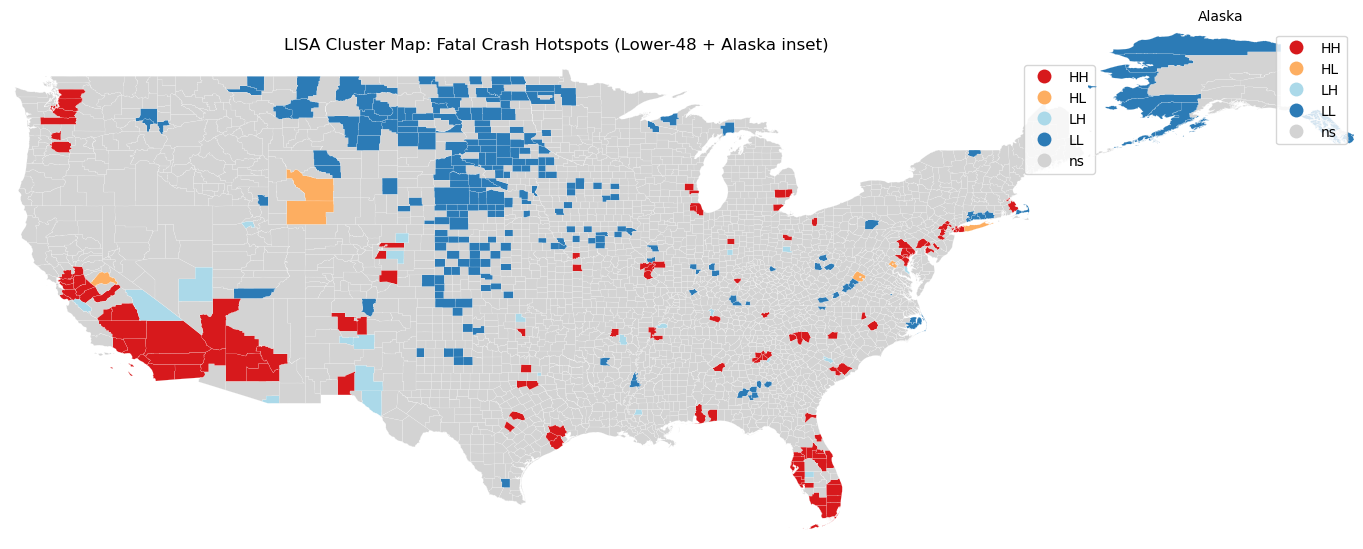

In [ ]:
import matplotlib.pyplot as plt
from splot.esda import lisa_cluster

fig = plt.figure(figsize=(14, 8))

# --- Main axis: lower-48 window ---
ax_main = fig.add_axes([0.03, 0.06, 0.78, 0.88])  # [left, bottom, width, height]
lisa_cluster(lisa, merged, p=0.05, ax=ax_main)

# zoom to lower-48 (lon/lat)
ax_main.set_xlim(-125, -66)
ax_main.set_ylim(24, 50)
ax_main.set_axis_off()
ax_main.set_title("LISA Cluster Map: Fatal Crash Hotspots (Lower-48 + Alaska inset)")

# --- Inset axis: Alaska window ---
ax_ak = fig.add_axes([0.80, 0.60, 0.19, 0.30])
lisa_cluster(lisa, merged, p=0.05, ax=ax_ak)

# zoom to Alaska (lon/lat)
ax_ak.set_xlim(-170, -130)
ax_ak.set_ylim(51, 72)
ax_ak.set_axis_off()
ax_ak.set_title("Alaska", fontsize=10)
plt.savefig("../outputs/figures/lisa_clusters_zoomed.png")
plt.show()
